In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100

In [68]:
datPath = ('H:\Document\Program\Kaggle\Titanic\\')
trainFile = 'train.csv'
testFile  = 'test.csv'

trainData = pd.read_csv(datPath + trainFile)
testData = pd.read_csv(datPath + testFile)

In [69]:
fullData = trainData.append(testData, ignore_index=True)

In [70]:
# see how many features in the training data
trainData.columns
#trainData['Pclass'].value_counts()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [19]:
'''

1. Visualize data


''' 

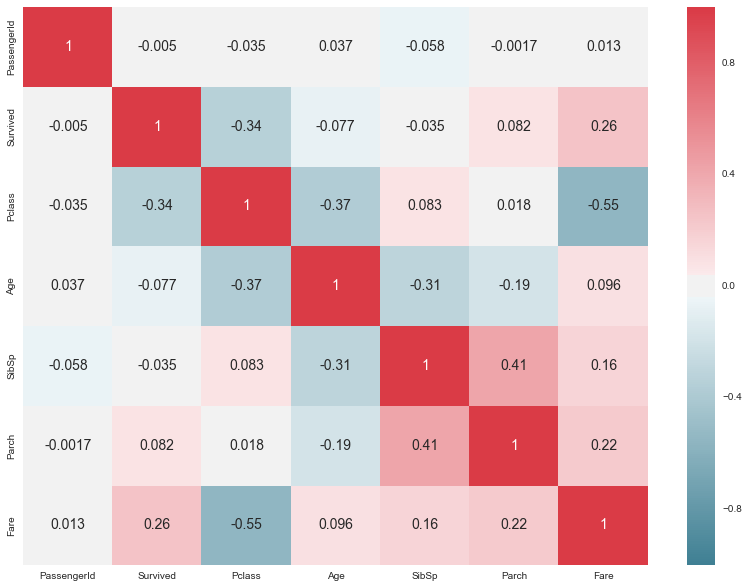

In [72]:
# 1.1 The most important is to plot the correlations among features and see how correlated they are

# we first get the correlation matrix of training dataseet
corrMat = trainData.corr()

# in order to plot the correaltion through heatmap, we need to setup the palette of sns
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(14,10))
# use heatmap from sns to plot the correlation matrix
corrHeatmap = sns.heatmap(corrMat, cmap=cmap, annot=True, annot_kws={'fontsize': 14})

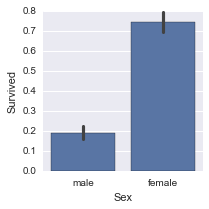

In [73]:
# 1.2 we plot the barplot of survival versus Age
sns.FacetGrid(trainData).map(sns.barplot, 'Sex','Survived')

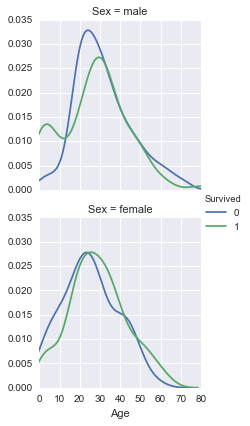

In [74]:
# 1.3 for the numerical feature, we then see the distribution of age versus survived under female and male groups
kdeAge = sns.FacetGrid(trainData, hue='Survived', row='Sex').map(sns.kdeplot, 'Age').add_legend()

# *** I initially implemented wrong *** #
kdeAge.set(xlim = (0, trainData['Age'].max()))

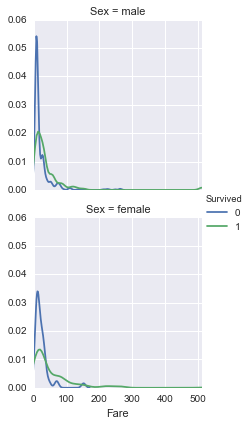

In [75]:
# 1.4 for the numerical feature, we then see the distribution of fare versus survived under female and male groups
kdefare = sns.FacetGrid(trainData, hue='Survived', row = 'Sex').map(sns.kdeplot,'Fare').add_legend()
kdefare.set(xlim=(trainData['Fare'].min(), trainData['Fare'].max()))

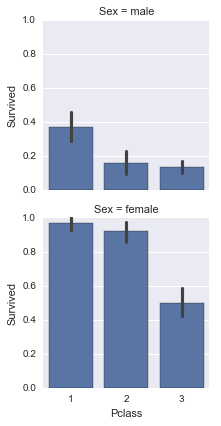

In [76]:
# 1.5 for the categorical feature, we use barplot to see what is going on in Pclass
barPclass = sns.FacetGrid(trainData, row = 'Sex').map(sns.barplot, 'Pclass', 'Survived').add_legend()

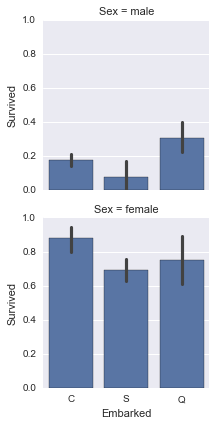

In [77]:
# 1.6 for the categorical feature, we use barplot to see what is going on in Embarked
barEmbarked = sns.FacetGrid(trainData, row = 'Sex').map(sns.barplot, 'Embarked', 'Survived').add_legend()

In [29]:
'''

2. clean data and feature engineering


''' 

'\n\n2. clean data\n\n\n'

In [78]:
# 2.1 we first see which features have NA data
NAColIndicator = np.where(fullData.isnull().values.mean(axis=0))

# create the string list to store all features' name
colStr = fullData.columns

# map the NA indicator to the string list and see which features have NA values
NACol = []
for n in np.arange(len(NAColIndicator[len(NAColIndicator)-1])):
    NACol.append(colStr[NAColIndicator[len(NAColIndicator)-1][n]])

# output all columns have NA values and see which one needs to be process
NACol

# because the test has no results for Survived, so after we concatenate training and test
# it makes sense that Survived has NA value, but we don't need to tackle it

['Age', 'Cabin', 'Embarked', 'Fare', 'Survived']

In [79]:
# In the features with NA value, we fill the mean of variables to the one which is numerical
fullData['Age'] = fullData['Age'].fillna(fullData['Age'].mean())
fullData['Fare'] = fullData['Fare'].fillna(fullData['Fare'].mean())

In [80]:
# for Embarked -- categorical feature, we use 'U' to represent the Unknown embarkation
fullData['Embarked'] = fullData['Embarked'].fillna('U')

In [81]:
# for Cabin -- categorical feature with too many possible values, we take the first letter to simplify it
# **** --- I did it wrong, without filling the NA value, we can't apply the map() function
fullData['Cabin'] = fullData['Cabin'].fillna('U')
fullData['Cabin'] = fullData['Cabin'].map(lambda cabin: cabin[0])

In [82]:
# transform the categorical features to dummy variables
Embarked = fullData['Embarked']
Embarked = pd.get_dummies(Embarked, prefix='Embarked')

Cabin = fullData['Cabin']
Cabin = pd.get_dummies(Embarked, prefix='Cabin')

Pclass = fullData['Pclass']
Pclass = pd.get_dummies(Pclass, prefix='Pclass')

In [83]:
fullData.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket'],
      dtype='object')

In [84]:
fullData['Ticket'].head(5)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [85]:
# we now deal with the Name feature, since what is the name of person seems irrelavant to the prediction,
# while the really matter is probabily his/her title, so we first abstract the title from Name feature
title = pd.DataFrame()
title['Title'] = fullData['Name'].map(lambda titleStr: titleStr.split(',')[1].split('.')[0].strip())

# because there are 18 possible values for Title feature, so we simplify the title by considered an 
# self-defined dictionary
len(title['Title'].value_counts())

# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir":       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess": "Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr":        "Mr",
                    "Mrs":       "Mrs",
                    "Miss":      "Miss",
                    "Master":    "Master",
                    "Lady":      "Royalty"
                    }

# then we map the title variable to the dictionary
title['Title'] = title['Title'].map(Title_Dictionary)

# make the title feature as a dummy variable
title = pd.get_dummies(title['Title'], prefix='Title')

In [150]:
#prob = np.arange(0.001, 1, 0.01)
#prob = pd.DataFrame(prob, columns=['probability'])
#prob['clfErr'] = prob['probability'].map(lambda p: 1 - max(p, (1-p)))
#prob['Gini'] = prob['probability'].map(lambda p: 2*(p*(1-p)))
#prob['CrosEntropy'] = prob['probability'].map(lambda p: -(p * np.log(p) + (1 - p) * np.log(1 - p)))
#prob['CrosEntropy'] = prob['probability'].map(lambda p: -(p*np.log(p)+(1-p)*np.log((1-p))))
##prob
##fig = plt.figure
#plt.plot(prob['probability'], prob['Gini'], color='red')
#plt.plot(prob['probability'], prob['CrosEntropy'], color='green')
#plt.plot(prob['probability'], prob['clfErr'], color='blue')
#plt.xlabel('Probability')

##c("red", "green", "blue")
##plt.legend([giniPlot, CrosEntropyPlot, clfErrPlot], ["Gini", "Cross Entropy", "Classfication Error"])
#plt.show()

In [86]:
# we process the 'Ticket' feature, the part we want is the string in 'Ticket' and therefore
# we need to do an additional step to get rid of the digit part and keep the sting part. 
# However, but we can apart the string and digit, we need to purify the string by removing '/' and '.'
# Because 'Ticket' has n realizations and each realization with two parts, so we need to write up
# a function and use map() function as iterator of all realizations
def cleanTicket(ticket):
    ticket = ticket.replace('/','').replace('.','')
    ticket = ticket.split()
    ticket = list(filter(lambda t: not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else:
        return 'XXX'

ticket = pd.DataFrame()
# cleanTicket is the function we wrote as iterator for visiting and processing all realizations in 'Ticket'
ticket['Ticket'] = fullData['Ticket'].map(cleanTicket)

# make it as a dummy variable
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )

In [87]:
# we then deal with Parch and SibSp features, the reason of thinking of these two features is 
# they are related to family size, so we can form a new feature call family by summing these two features
family = pd.DataFrame()
familySize = pd.DataFrame()
family['familySize'] = fullData['Parch'] + fullData['SibSp'] + 1
#family['familySize'].value_counts()

# In the new family feature, we have nine possible values for variables which is too much.
# Hence, we make it as a categorical variable which has only three group: single, small and large
familySize['Family_Single'] = family['familySize'].map(lambda fs: 1 if fs == 1 else 0)
familySize['Family_Small'] = family['familySize'].map(lambda fs: 1 if 2 <= fs <= 4 else 0)
familySize['Family_Large'] = family['familySize'].map(lambda fs: 1 if 5 <= fs else 0)


In [88]:
# because some learning algorithms can't handle the string variables, so we need to convert Sex feature
# from string to binary values
fullData['Sex'] = np.where(fullData['Sex'] == 'female', 0, 1)

In [89]:
# we eventually form the processed new full dataset by concatenate all features together
newFullData = pd.concat([fullData['Age'], fullData['Fare'], title, 
                         Cabin, Embarked, Pclass, ticket, familySize, fullData['Sex']], axis = 1)

In [282]:
'''

3. feature selection

''' 

'\n\n3. feature selection\n\n'

In [21]:
newFullData.shape

(1309, 60)

In [90]:
# we can use some basic learning algorithms to get feature importance, 
# but before we could fit the data to learning algorithms, 
# we need to split our training data into sub-training and validation, and also define the test dataset
from sklearn.cross_validation import train_test_split
newTrainData = newFullData[0:trainData.shape[0]]
newTrainDataOut = trainData['Survived']
newTestData = newFullData[trainData.shape[0]:]

subTrain_x, validation_x, subTrain_y, validation_y = train_test_split(newTrainData, newTrainDataOut, train_size=0.4)
print('size of full data set is:', newFullData.shape, 'size of train input space is:', subTrain_x.shape,
      'size of train output space is:', subTrain_y.shape, 'size of validation input space is:', validation_x.shape,
      'size of validation output space is:', validation_y.shape, 'size of test input space is:', newTestData.shape)



size of full data set is: (1309, 60) size of train input space is: (356, 60) size of train output space is: (356,) size of validation input space is: (535, 60) size of validation output space is: (535,) size of test input space is: (418, 60)


In [23]:
# then we can fit the subTraining dataset to the simple decision tree 
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(subTrain_x, subTrain_y)

# take a look on feature importance
DT.feature_importances_

# which is unordered, and unnamed, so we create a DataFrame to store this feature importance
varImp = pd.DataFrame(DT.feature_importances_, columns=['feature importance'], index=subTrain_x.columns)
# then sort the varImp
varImp = varImp.sort('feature importance', ascending=False)

In [24]:
# we plot out the variable importance
varImp[0:10][::-1].plot(kind='barh')
plt.show()

In [371]:
'''

4. Model Selection

''' 

In [25]:
# Random Forests Model
from sklearn.ensemble import RandomForestClassifier

# Support Vector Machines
from sklearn.svm import SVC

# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

# K-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Logistic Regression
from sklearn.linear_model import LogisticRegression


In [26]:
# train random forest
RFmodel = RandomForestClassifier(n_estimators=100)
RFmodel.fit(subTrain_x, subTrain_y)
RFmodelTrainScor = RFmodel.score(subTrain_x, subTrain_y)
RFmodelValidScor = RFmodel.score(validation_x, validation_y)

In [27]:
# train SVM
SVCModel = SVC(kernel = 'linear', C = 0.01)
SVCModel.fit(subTrain_x, subTrain_y)
SVCModelTrainScor = SVCModel.score(subTrain_x, subTrain_y)
SVCModelValidScor = SVCModel.score(validation_x, validation_y)

In [28]:
# train Gradient Boosting Classifier
GBCModel = GradientBoostingClassifier(max_depth=1, learning_rate=0.01)
GBCModel.fit(subTrain_x, subTrain_y)
GBCModelTrainScor = GBCModel.score(subTrain_x, subTrain_y)
GBCModelValidScor = GBCModel.score(validation_x, validation_y)

In [29]:
# train K-nearest neighbors
KNNModel = KNeighborsClassifier(n_neighbors=3)
KNNModel.fit(subTrain_x, subTrain_y)
KNNModelTrainScor = KNNModel.score(subTrain_x, subTrain_y)
KNNModelValidScor = KNNModel.score(validation_x, validation_y)

In [30]:
# Gaussian Naive Bayes
GNBModel = GaussianNB()
GNBModel.fit(subTrain_x, subTrain_y)
GNBModelTrainScor = GNBModel.score(subTrain_x, subTrain_y)
GNBModelValidScor = GNBModel.score(validation_x, validation_y)

In [31]:
# Logistic Regression
LogRegModel = LogisticRegression()
LogRegModel.fit(subTrain_x, subTrain_y)
LogRegModelTrainScor = LogRegModel.score(subTrain_x, subTrain_y)
LogRegModelValidScor = LogRegModel.score(validation_x, validation_y)

In [32]:
# create an DataFrame with having training score and test score
performance = pd.DataFrame([[RFmodelTrainScor, RFmodelValidScor],[SVCModelTrainScor, SVCModelValidScor],
                            [GBCModelTrainScor, GBCModelValidScor],[KNNModelTrainScor, KNNModelValidScor],
                            [GNBModelTrainScor, GNBModelValidScor],[LogRegModelTrainScor, LogRegModelValidScor]],
                           columns=['training', 'validation'],
                           index=['Random Forest','SVM','Gradient Boosting','KNN','Gausian Naive Bayes','Logistic Regression'])

In [33]:
perf = performance.max(axis=0)
BestModelInTraining = performance[performance['training'] == perf[0]].index[0]
BestModelInvalidation = performance[performance['validation'] == perf[1]].index[0]

In [34]:
print('The model with highest training score is:', BestModelInTraining, 'with score:', perf[0],
      '\nThe model with highest validation score is:', BestModelInvalidation, 'with score:', perf[1])

The model with highest training score is: Random Forest with score: 0.991573033708 
The model with highest validation score is: Logistic Regression with score: 0.818691588785


In [ ]:
'''

5. Feature importance - selecting the optimal features in the model

''' 

In [35]:
# use recrusive feature elimination with cross validation to acheive feature selection
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import StratifiedKFold
rfecv = RFECV(estimator=LogRegModel, step=1, cv=StratifiedKFold(subTrain_y, 3), scoring='accuracy')
rfecv.fit(subTrain_x, subTrain_y)

RFECV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 0 1], n_folds=3, shuffle=False, random_state=None),
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

In [36]:
print (rfecv.score( subTrain_x , subTrain_y) , rfecv.score( validation_x , validation_y ))
print( "Optimal number of features : %d" % rfecv.n_features_ )

0.825842696629 0.818691588785
Optimal number of features : 34


In [432]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel( "Number of features selected" )
plt.ylabel( "Cross validation score (number of correct classifications)" )
plt.plot( range( 1 , len( rfecv.grid_scores_ ) + 1 ) , rfecv.grid_scores_ )
plt.show()

In [37]:
# with training logistic with all features in training set, we make prediction
logPred = LogRegModel.predict(newTestData)
PassengerID = fullData['PassengerId'][trainData.shape[0]:]
testResult = pd.DataFrame({'Predicted Survival': np.where(logPred==1, 'Survived', 'Dead'), 
                           'PassengerID': PassengerID})

In [38]:
testResult['Predicted Survival'].value_counts()

Dead        263
Survived    155
Name: Predicted Survival, dtype: int64

In [39]:
# we then use the reduced feature space to re-train the logistic regression
featureSelectData_x = newFullData[0:trainData.shape[0]]
featureSelectData_x = featureSelectData_x[[varImp.index[0],varImp.index[1],varImp.index[2],varImp.index[3]]]
featureSelectData_y = fullData['Survived'][0:trainData.shape[0]]

In [40]:
# do validation test and see how much improvement acheived by feature selection
FS_subTrain_x, FS_validation_x, FS_subTrain_y, FS_validation_y = train_test_split(featureSelectData_x, 
                                                                                  featureSelectData_y,train_size=0.4)
FS_subTrainLogReg = LogisticRegression()
FS_subTrainLogReg.fit(FS_subTrain_x, FS_subTrain_y)
print(FS_subTrainLogReg.score(FS_subTrain_x, FS_subTrain_y), FS_subTrainLogReg.score(FS_validation_x, FS_validation_y))

0.786516853933 0.78691588785


In [41]:
# re-training the logistic regression
featureSelectedLogReg = LogisticRegression()
featureSelectedLogReg.fit(featureSelectData_x, featureSelectData_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
# with re-training logistic with selected features in training set, we make prediction
#newTestData = newTestData[chunkVarImp]
newTestData = newTestData[[varImp.index[0],varImp.index[1],varImp.index[2],varImp.index[3]]]
featureSelectedLogRegPred = featureSelectedLogReg.predict(newTestData)
PassengerID = fullData['PassengerId'][trainData.shape[0]:]
featureSelectedLogRegtestResult = pd.DataFrame({'Predicted Survival': np.where(featureSelectedLogRegPred==1, 'Survived', 'Dead'), 
                           'PassengerID': PassengerID})
featureSelectedLogRegtestResult['Predicted Survival'].value_counts()

Dead        268
Survived    150
Name: Predicted Survival, dtype: int64

In [43]:

varImpList = list(varImp[0:rfecv.n_features_].index.values)

In [44]:
chunkVarImp = [varImpList[x:x+1] for x in range(0, len(varImpList))]

In [45]:
chunkVarImp

[['Sex'],
 ['Fare'],
 ['Age'],
 ['Pclass_3'],
 ['Family_Small'],
 ['Title_Master'],
 ['Title_Officer'],
 ['Ticket_WC'],
 ['Family_Large'],
 ['Ticket_SWPP'],
 ['Title_Miss'],
 ['Ticket_STONO'],
 ['Ticket_C'],
 ['Title_Mrs'],
 ['Embarked_S'],
 ['Ticket_XXX'],
 ['Embarked_Q'],
 ['Embarked_C'],
 ['Ticket_A5'],
 ['Ticket_SOP'],
 ['Ticket_SCAH'],
 ['Ticket_SCOW'],
 ['Ticket_SCA4'],
 ['Ticket_SCPARIS'],
 ['Ticket_SCParis'],
 ['Ticket_SOC'],
 ['Ticket_STONO2'],
 ['Ticket_SOPP'],
 ['Ticket_SOTONO2'],
 ['Ticket_SOTONOQ'],
 ['Ticket_SP'],
 ['Ticket_SC'],
 ['Ticket_STONOQ'],
 ['Ticket_WEP']]

In [46]:
varImp.index[0],varImp.index[1]

('Sex', 'Fare')

In [ ]:
'''

5. find the best set of parameters by a process called grid search

''' 

In [52]:
from sklearn.model_selection import GridSearchCV

model_para = {'n_estimators': [100, 500, 100], 'max_features': [3,8,20]}
RFModel = RandomForestClassifier()
#n_jobs=1, cv=10, verbose=20, scoring=RMSE
RFModelSearch = GridSearchCV(estimator = RFModel, param_grid= model_para,
                            n_jobs = 1, cv = 5)
RFModelSearch.fit(subTrain_x, subTrain_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 500, 100], 'max_features': [3, 8, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [53]:
RFModelSearch.score(validation_x, validation_y)

0.82056074766355136

In [63]:
# Randomized Search

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
            
RFC = RandomForestClassifier(n_estimators=1000)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
n_iter = 20

RF_OptimRandom_model = RandomizedSearchCV(estimator = RFC, param_distributions = param_dist, n_iter=n_iter, cv = 5)
RF_OptimRandom_model.fit(subTrain_x, subTrain_y)

start = time()
RF_OptimRandom_model.fit(subTrain_x, subTrain_y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(RF_OptimRandom_model.cv_results_)


ValueError: min_samples_split must be at least 2 or in (0, 1], got 1

In [62]:
RF_OptimRandom_model.best_estimator_.score(validation_x, validation_y)

0.82242990654205606